<a href="https://colab.research.google.com/github/hyang0129/hyang0129/blob/main/Discriminative_Learning_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOW TO USE DISCRIMINATIVE LEARNING RATES IN TENSORFLOW

Discriminative learning rates is a common technique in transfer learning. The premise of this technique is that the earlier layers of the network contain general features and the latter layers of the network contain more specialized features. If this is true, then when we wish to transfer knowledge from a pretrained network, we would want to preserve the general features and focus on optimizing the specialized features. This can be accomplished by assigning different learning rates to different layers. 

I have implemented a special optimizer for Tensorflow that allows for easy implementation of discriminative learning rates. My implementation of the Multi Optimizer is a class available in Tensorflow Addons and allows for different optimizers to be assigned to each set of layers. Below is a demonstration on how to use the Multi Optimizer.

Here is a more in depth explaination of discriminative learning rates a.k.a. differential learning rates. https://blog.slavv.com/differential-learning-rates-59eff5209a4f 


# SETUP

You will need to install the latest version of tensorflow addons and tensorflow datasets.

If you are running this for the first time, please allow approximately 5 minutes for the food101 dataset to download to the cloud instance. 



In [ ]:
!pip install tensorflow-addons tensorflow-datasets  --upgrade


     |████████████████████████████████| 706kB 13.9MB/s 
     |████████████████████████████████| 3.7MB 29.1MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_addons as tfa 
from tqdm.notebook import tqdm
import math
import os

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


In [ ]:


train_ds, test_ds = tfds.load('food101', split=['train', 'validation'])

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# HYPER PARAMETERS

Below are the hyper parameters. You may adjust them and experiment.

In this case we are looking at a low LR and a high LR.

In [ ]:
TARGET_IMAGE_SIZE = 128 
BATCH_SIZE = 128

DISC_LR = [1e-5, 1e-4]

NUM_CLASS = 101

STEPS_PER_EPOCH = 200
EPOCHS = 20


# AUGMENTATIONS

Please note that the augmentations and other code below are compatible with TPUs. The only thing not compatible with TPUs is the dataset, which must be hosted on Google Cloud Storage. 

The augmentations are a combination of rotation, shift, zoom, and shear. 

## CODE

In [ ]:

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def get_matrix(): 
    rot = 15.0  * tf.random.normal([1], dtype='float32')
    shr = 2.0 * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    h_shift = 8.0 * tf.random.normal([1], dtype='float32') 
    w_shift = 8.0 * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 
    return m 


def transform(image, matrix, DIM ):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted

    m = matrix

    XDIM = DIM%2 #fix for size 331
    

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,-1])

def augment(example): 

    matrix = get_matrix() 

    example['image'] = transform(example['image'], matrix, TARGET_IMAGE_SIZE)

    return example 

def resize_image(example): 
    image = example['image']

    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize_with_pad(image, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)

    example['image'] = image

    return example 


def to_tuple(example):

    return (example['image'], example['label'])

def draw_grid(imgs, nrow, ncol):

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

    for i, ax in enumerate(axs.reshape(-1)):

        img = imgs[i].numpy()
        
        ax.imshow(img)



## IMAGES WITHOUT AUGMENTATION


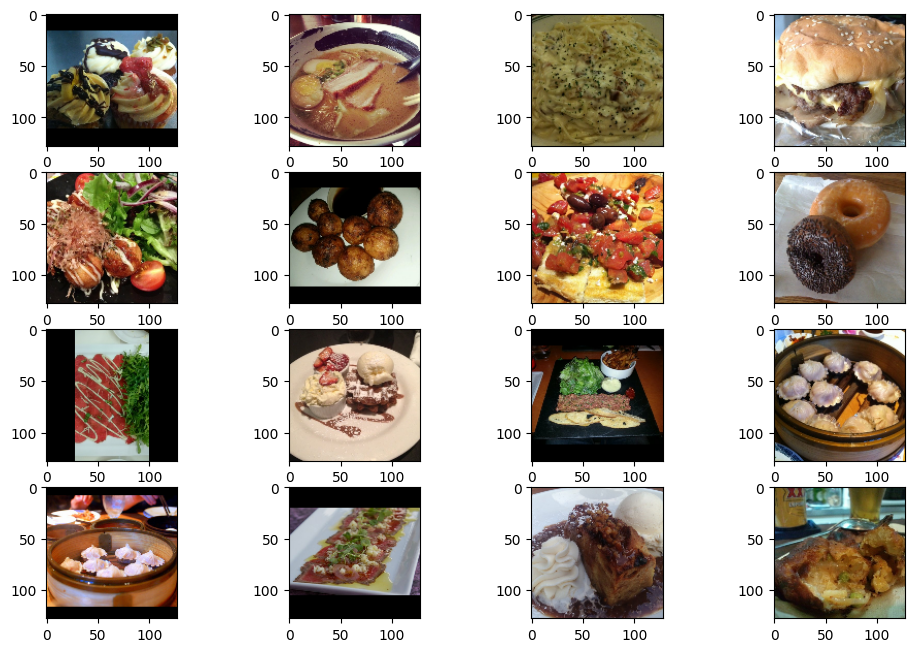

In [ ]:
imgs = list(test_ds.map(resize_image).batch(8).take(1))[0]['image']

draw_grid(imgs, 2, 4)



## IMAGES WITH AUGMENTATION

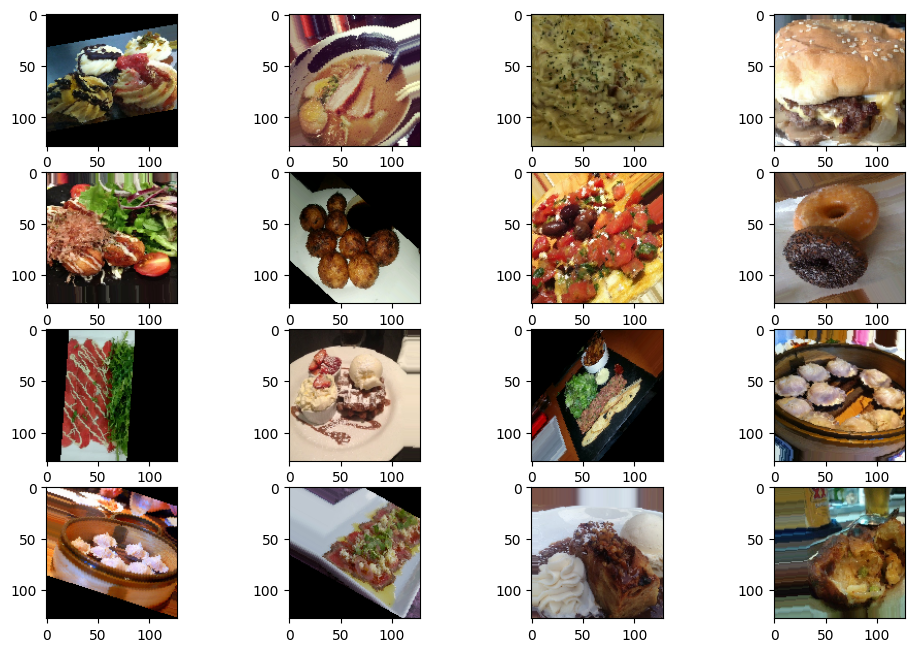

In [ ]:
imgs = list(test_ds.map(resize_image).map(augment).batch(8).take(1))[0]['image']

draw_grid(imgs, 2, 4)



# MODEL DEFINITION

Below is how to compile a model for use with Multi Optimizer. You can define an arbitrary number of layer groups due to how Multi Optimizer was implemented in the graph with negligible performance loss. This is because the gradients for all layers are computed in a single operation and then routed to the correct optimizers. 

In [ ]:

def get_pretrained_model(model_fn = tf.keras.applications.EfficientNetB4):

    base = model_fn(input_shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False,
            pooling = 'avg')

    top = tf.keras.layers.Dense(NUM_CLASS, activation = 'softmax') 

    model = tf.keras.Sequential([base, top])

    return model 


def compile_model(model, disc = True, lr = None ):

    if disc: 

        # define an optimizer for each set of layers 
        optimizers = [tf.keras.optimizers.Adam(learning_rate=DISC_LR[0]),
              tf.keras.optimizers.Adam(learning_rate=DISC_LR[1])
              ]

        # combine the optimize and layer pairs into a list of tuples 
        optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1:])] 

        # instantiate a multi optimizer class from the pairs 
        optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

        #afterwards, the optimizer functions the same as a normal optimizer 

    elif lr is not None: 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    else: 
        assert lr is not None, "You need to specify disc or lr"
        

    
    model.compile(optimizer=optimizer, 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics = tf.keras.metrics.SparseCategoricalAccuracy()
                )
    
    return model 



model = get_pretrained_model()

model = compile_model(model, disc = True)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_1 (Dense)              (None, 101)               181093    
Total params: 17,854,916
Trainable params: 17,729,709
Non-trainable params: 125,207
_________________________________________________________________


# TRAINING

Here we define the datasets to be used for training and testing. 

In [ ]:

train_dataset = (train_ds
                 .map(resize_image)
                 .map(augment)
                 .map(to_tuple)
                 .shuffle(10000)
                 .batch(BATCH_SIZE)
                 .repeat())

test_dataset = (test_ds
                .map(resize_image)
                .map(to_tuple)
                .batch(BATCH_SIZE))


results = {} 



## WITHOUT DISCRIMINATIVE LEARNING RATES

Here we use the higher learning rate. It appears quite unstable. 

In [ ]:




model = get_pretrained_model()

model = compile_model(model, disc = False, lr = DISC_LR[1])


history = model.fit(train_dataset,
          steps_per_epoch = STEPS_PER_EPOCH,
          epochs = EPOCHS,
          validation_data = test_dataset)


results['standard_1e-4'] = history 



Epoch 1/20
200/200 [==============================] - 275s 1s/step - loss: 4.5830 - sparse_categorical_accuracy: 0.0273 - val_loss: 4.8167 - val_sparse_categorical_accuracy: 0.0097
Epoch 2/20
200/200 [==============================] - 212s 1s/step - loss: 3.6492 - sparse_categorical_accuracy: 0.1830 - val_loss: 5.2772 - val_sparse_categorical_accuracy: 0.0111
Epoch 3/20
200/200 [==============================] - 216s 1s/step - loss: 2.8631 - sparse_categorical_accuracy: 0.3208 - val_loss: 5.0877 - val_sparse_categorical_accuracy: 0.0323
Epoch 4/20
200/200 [==============================] - 211s 1s/step - loss: 2.4418 - sparse_categorical_accuracy: 0.3985 - val_loss: 3.3971 - val_sparse_categorical_accuracy: 0.2262
Epoch 5/20
200/200 [==============================] - 217s 1s/step - loss: 2.1659 - sparse_categorical_accuracy: 0.4560 - val_loss: 2.8816 - val_sparse_categorical_accuracy: 0.3139
Epoch 6/20
200/200 [==============================] - 216s 1s/step - loss: 1.9420 - sparse_cate

## WITH DISCRIMINATIVE LEARNING RATES

Here we use the lower rate for the earlier layers and the higher rate for only the final layer. The validation metrics are much more stable.

In [ ]:



model = get_pretrained_model()

model = compile_model(model, disc = True)


history = model.fit(train_dataset,
          steps_per_epoch = STEPS_PER_EPOCH,
          epochs = EPOCHS,
          validation_data = test_dataset)

results['mixed_1e-4_1e-5'] = history 


Epoch 1/20
200/200 [==============================] - 261s 1s/step - loss: 4.6724 - sparse_categorical_accuracy: 0.0124 - val_loss: 4.6791 - val_sparse_categorical_accuracy: 0.0099
Epoch 2/20
200/200 [==============================] - 219s 1s/step - loss: 4.5293 - sparse_categorical_accuracy: 0.0312 - val_loss: 4.6543 - val_sparse_categorical_accuracy: 0.0139
Epoch 3/20
200/200 [==============================] - 211s 1s/step - loss: 4.3417 - sparse_categorical_accuracy: 0.0680 - val_loss: 4.4552 - val_sparse_categorical_accuracy: 0.0380
Epoch 4/20
200/200 [==============================] - 211s 1s/step - loss: 4.1011 - sparse_categorical_accuracy: 0.1106 - val_loss: 3.9172 - val_sparse_categorical_accuracy: 0.1336
Epoch 5/20
200/200 [==============================] - 210s 1s/step - loss: 3.8507 - sparse_categorical_accuracy: 0.1463 - val_loss: 3.6292 - val_sparse_categorical_accuracy: 0.1766
Epoch 6/20
200/200 [==============================] - 212s 1s/step - loss: 3.6468 - sparse_cate

## WITH JUST A LOWER LEARNING RATE

If the learning rate is too low, then we don't make much progress during training

In [ ]:



model = get_pretrained_model()

model = compile_model(model, disc = False, lr = DISC_LR[0])


history = model.fit(train_dataset,
          steps_per_epoch = STEPS_PER_EPOCH,
          epochs = EPOCHS,
          validation_data = test_dataset)

results['standard_1e-5'] = history 


Epoch 1/20
200/200 [==============================] - 258s 1s/step - loss: 4.6933 - sparse_categorical_accuracy: 0.0115 - val_loss: 4.6876 - val_sparse_categorical_accuracy: 0.0090
Epoch 2/20
200/200 [==============================] - 208s 1s/step - loss: 4.6487 - sparse_categorical_accuracy: 0.0129 - val_loss: 4.6716 - val_sparse_categorical_accuracy: 0.0113
Epoch 3/20
200/200 [==============================] - 208s 1s/step - loss: 4.5905 - sparse_categorical_accuracy: 0.0218 - val_loss: 4.6101 - val_sparse_categorical_accuracy: 0.0199
Epoch 4/20
200/200 [==============================] - 207s 1s/step - loss: 4.5351 - sparse_categorical_accuracy: 0.0300 - val_loss: 4.4684 - val_sparse_categorical_accuracy: 0.0500
Epoch 5/20
200/200 [==============================] - 209s 1s/step - loss: 4.4648 - sparse_categorical_accuracy: 0.0483 - val_loss: 4.3703 - val_sparse_categorical_accuracy: 0.0728
Epoch 6/20
200/200 [==============================] - 208s 1s/step - loss: 4.3872 - sparse_cate

# SUMMARY

Below is a plot of the validation loss over time. 

As you can see, using discriminative learning rates allows you to train faster without destabilizing the training process. 

Additional fine tuning can be done to further improve the performance. For example, only the final layer used the higher learning rate. Adding more later layers to the higher learning rate group will allow for faster training. We can also add a new group, perhaps an intermediate learning rate group for layers in the middle. 

There are many possibilities for leveraging discriminative learning rates to improve transfer learning. My implementation of the Multi Optimizer simplifies the process for tensorflow models. 

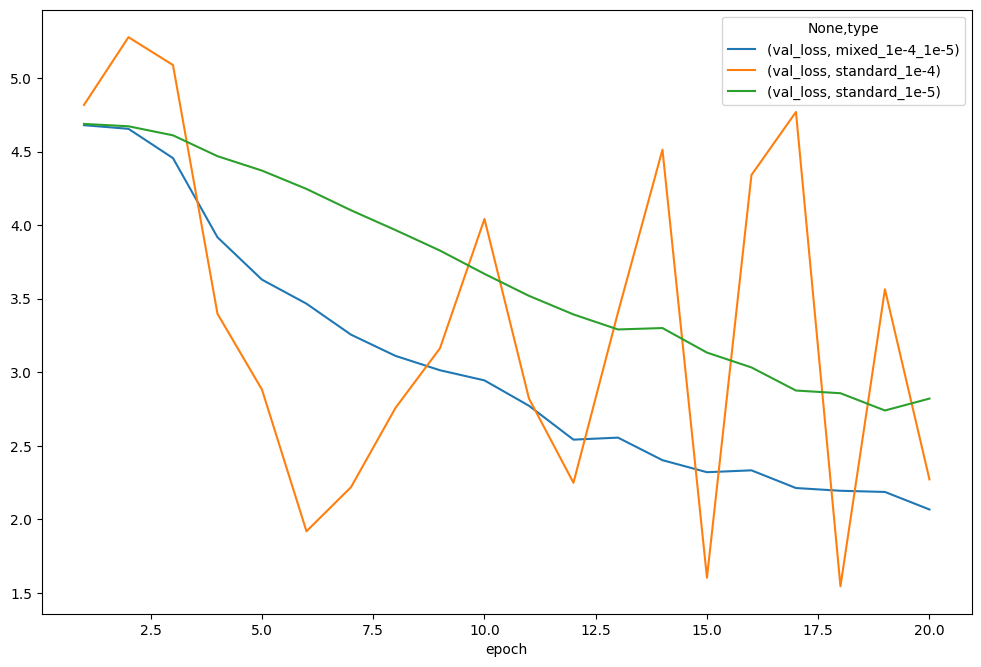

In [ ]:
import pandas as pd

dfs = [] 

for k,v in results.items():
    
    res = pd.DataFrame(v.history)

    res['type'] = k
    res['epoch'] = [i for i in range(1,21)]
    dfs.append(res)

df = pd.concat(dfs)

# plt.plot()


df[['val_loss', 'type', 'epoch']].pivot('epoch', 'type').plot()

